In [6]:
# Third party
import importlib
import torch
import matplotlib.pyplot as plt

# User
import base.abstract
import base.mlp
import base.train
import base.encode
import base.pre_process
import model
import attention

importlib.reload(base.abstract)
importlib.reload(base.mlp)
importlib.reload(base.train)
importlib.reload(base.encode)
importlib.reload(base.pre_process)
importlib.reload(base.norm)
importlib.reload(model)
importlib.reload(attention)

from base.train import sgd
from base.encode import get_encoder_decoder
from base.mlp import LinearLayer, MLP
from base.train import sgd
from base.pre_process import get_dataset
from model import SimpleTransformer, Transformer
from attention import BatchedSelfAttentionHead
from encode import positional_encode

In [7]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))

In [8]:
token_length = 32
dataset =  get_dataset(text_encoded, token_length, context_window="expanding")
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)


(948085, 167309)

In [9]:

g = torch.Generator().manual_seed(2147483647)

hp = {
    "init_learning_rate": .001,
    "converging_learning_rate": .01,
    "epochs": 10000,
    "epochs_log_interval": 100,
    "dim_of_embedding": 64,
    "num_of_attention_heads": 4,
    "num_of_attention_blocks": 4,
    "num_layer_1_nodes": 15,
    "mini_batch_size": 32,
    "token_length": token_length,
}

params = {
    "num_of_unique_chars": len(unique_chars),
    "positional_encoding_func": positional_encode,
    "attention_block_type": "decoder"
}

l1 = LinearLayer(
    num_of_inputs=hp['dim_of_embedding'], #3x8x3 3x10 = 3x8x10
    num_of_neurons=hp["num_layer_1_nodes"],
    append_pre_activation_layer=True,
    activation_func=torch.tanh,
    generator=g
)
l2 = LinearLayer(
    num_of_inputs=hp["num_layer_1_nodes"],
    num_of_neurons=hp["dim_of_embedding"],
    activation_func=torch.tanh,
    generator=g
)

mlp_model = MLP(layers=[l1,l2])
attention_model = Transformer(hp, mlp_model, generator=g,**params)



In [114]:
# t = train_data[[4,5]]
# attention_model.forward(t)

KeyboardInterrupt: 

In [10]:
attention_model.require_grad()
loss_list = []
sgd(hp
    , attention_model
    , training_inputs=train_data
    , training_targets=train_targets
    , loss_list=loss_list
)


epoch: 0 / 10000, loss: 17.7932
epoch: 100 / 10000, loss: 13.8573
epoch: 200 / 10000, loss: 10.3830
epoch: 300 / 10000, loss: 8.3898
epoch: 400 / 10000, loss: 7.6782
epoch: 500 / 10000, loss: 7.8656
epoch: 600 / 10000, loss: 7.0717
epoch: 700 / 10000, loss: 6.6813
epoch: 800 / 10000, loss: 6.4525
epoch: 900 / 10000, loss: 6.1564
epoch: 1000 / 10000, loss: 5.7388
epoch: 1100 / 10000, loss: 5.5362
epoch: 1200 / 10000, loss: 5.3696
epoch: 1300 / 10000, loss: 4.8910
epoch: 1400 / 10000, loss: 4.9397
epoch: 1500 / 10000, loss: 4.7974
epoch: 1600 / 10000, loss: 4.6554
epoch: 1700 / 10000, loss: 4.6817
epoch: 1800 / 10000, loss: 4.3965
epoch: 1900 / 10000, loss: 4.3086
epoch: 2000 / 10000, loss: 4.3086
epoch: 2100 / 10000, loss: 4.2765
epoch: 2200 / 10000, loss: 4.1606
epoch: 2300 / 10000, loss: 4.1831
epoch: 2400 / 10000, loss: 4.1096
epoch: 2500 / 10000, loss: 3.9626
epoch: 2600 / 10000, loss: 4.0596
epoch: 2700 / 10000, loss: 3.9601
epoch: 2800 / 10000, loss: 3.9352
epoch: 2900 / 10000, lo

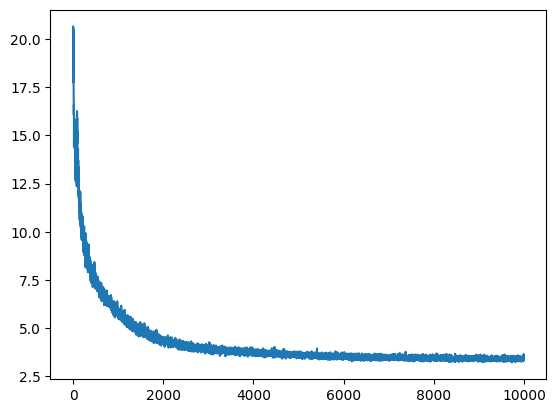

In [11]:
plt.plot(loss_list)


In [12]:
# Compute negative log likelihood of the train/validation

print(f"train loss: {attention_model.dataset_loss(train_data, train_targets)}")
print(f"validation loss: {attention_model.dataset_loss(validation_data, validation_targets)}" )

KeyboardInterrupt: 

In [ ]:
print(decoder(attention_model.generate(1000)))